In [40]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
import cmocean
import cmocean.cm as cmo
import cmcrameri
import cmcrameri.cm as cmc
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from typing import List, Any
import os
import pandas as pd

In [1]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

rcoll = sgl.create_roicollection_from_csv(settings18, name = "shackleton")

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
=====> Get ROICollection from csv roi.csv
     | 16 regions created.


In [3]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

In [4]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_10.shp"))

In [5]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_10.shp"))

In [6]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

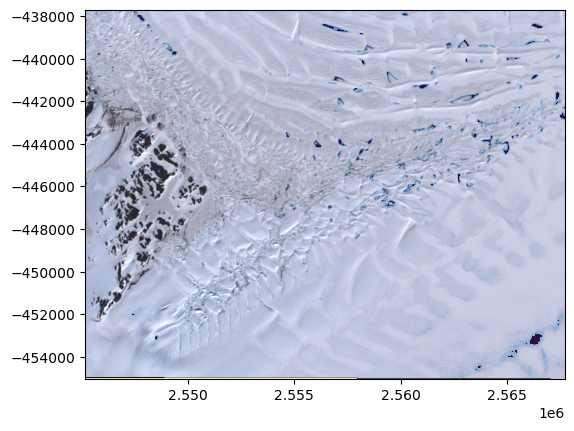

In [129]:
date = "2020-01-22"
w_shape = rcoll.get("E")
name = "tile-182"
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""tiff"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_reduced)) as src:
    meta = src.meta
    tif_clipped, tif_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

fig, ax = plt.subplots()
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
rplt.show(tif_clipped[1], transform = tif_transform, ax = ax,  cmap = cmo.matter)

In [132]:
settings = settings19
coll = coll19

tile-182_S1_20191101_20191110_30m.tif


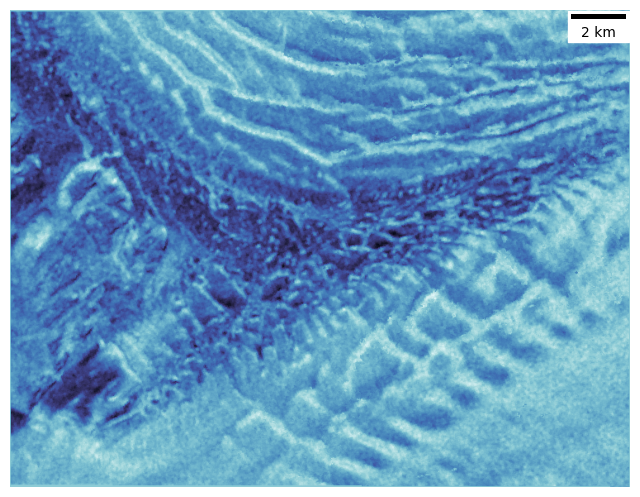

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


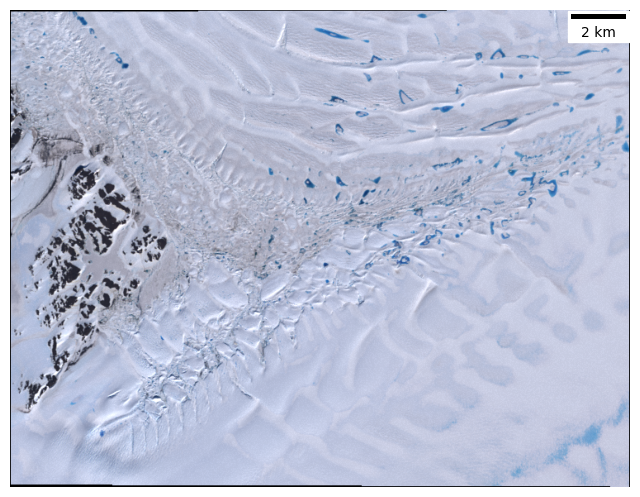

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


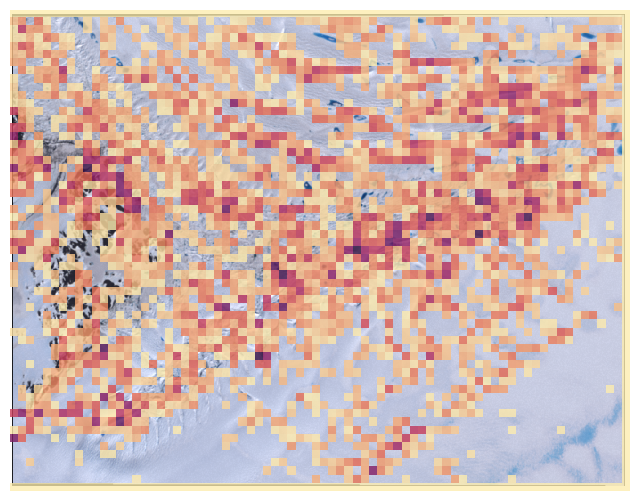

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


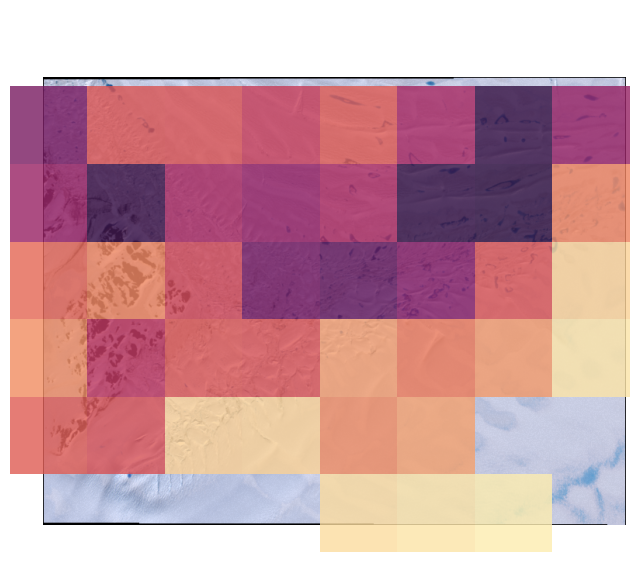

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


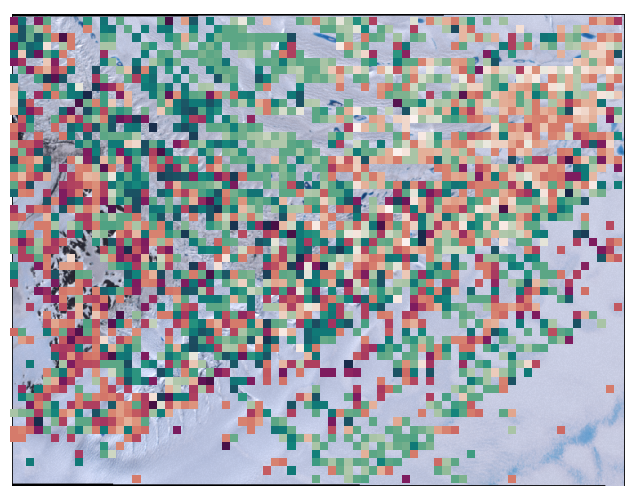

In [257]:
date = "2020-01-22"
w_shape = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""S1"""
filename = "_".join([name, "S1_20191101", "20191110", "30m.tif"])
print(filename)
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    S1_clipped, S1_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""dmg"""
with rasterio.open(os.path.join(settings.dmg_folder, w0.file_dmg)) as src:
    meta = src.meta
    dmg_clipped, dmg_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "dmg.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    dmg_resampled, dmg_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


"""crev angle"""
with rasterio.open(os.path.join(r"D:\[NOT SYNC]\ASRP_Data\shackleton_S1_30m\tile-182_S1_20191101_20191110_30m_output_10px_alphaC.tif")) as src:
    meta = src.meta
    alpha_c_clipped, alpha_v_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(S1_clipped, transform = S1_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)

rplt.show(dmg_clipped, transform = dmg_transform, ax = ax,  cmap = cmo.matter, alpha = 0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_resampled[dmg_resampled <= median] = np.nan
rplt.show(dmg_resampled, transform = dmg_resampled_transform, ax = ax,  cmap = cmo.matter, alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_mask = np.zeros(dmg_clipped.shape)
dmg_mask = dmg_mask * np.nan
dmg_mask[dmg_clipped > 0] = 1
rplt.show(alpha_v_clipped*dmg_mask, transform = alpha_v_transform, ax = ax,  cmap = cmo.curl, alpha = 1, vmin = -90, vmax = 90)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

tile-182_S1_20191101_20191110_30m.tif


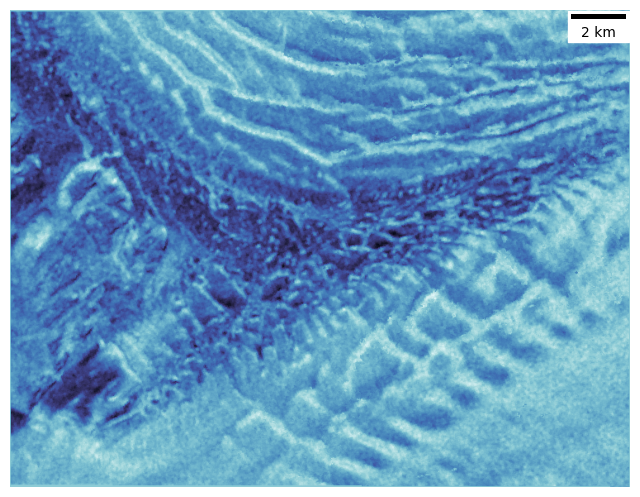

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


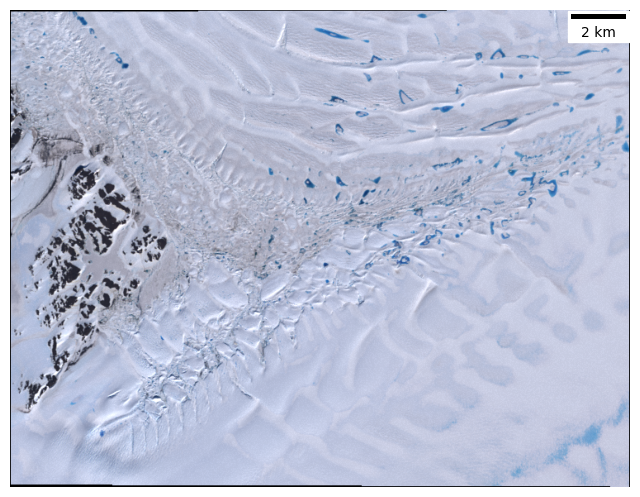

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


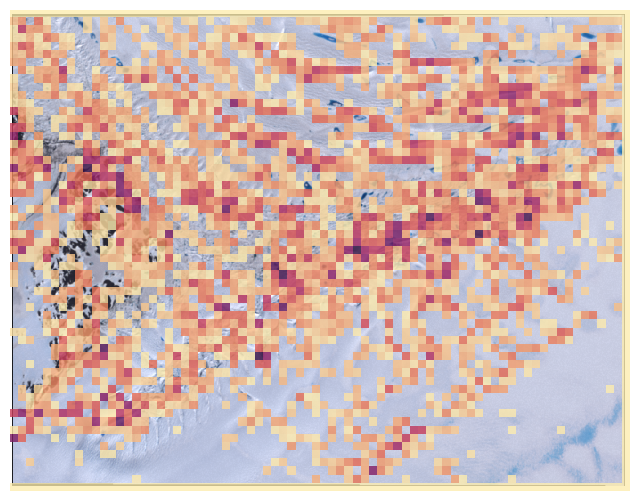

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


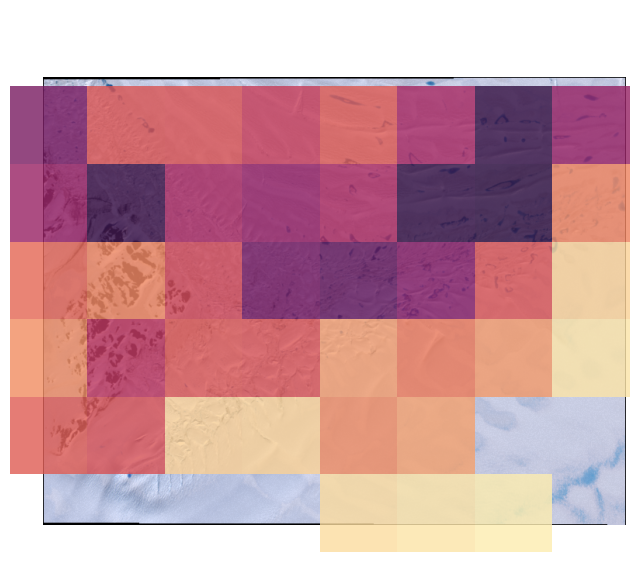

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


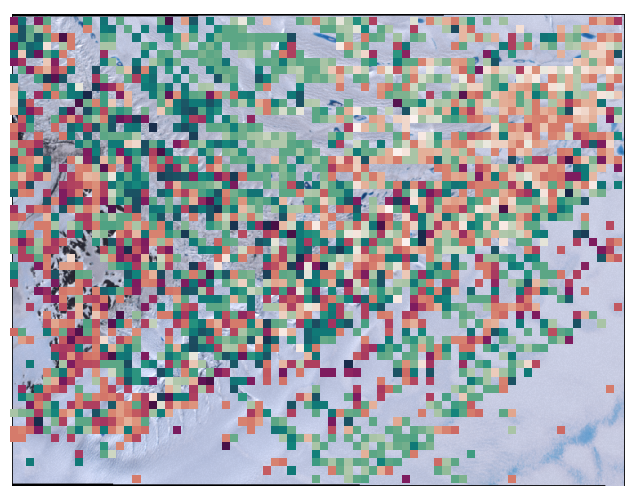

In [263]:
date = "2020-01-22"
w_shape = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""S1"""
filename = "_".join([name, "S1_20191101", "20191110", "30m.tif"])
print(filename)
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    S1_clipped, S1_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""dmg"""
with rasterio.open(os.path.join(settings.dmg_folder, w0.file_dmg)) as src:
    meta = src.meta
    dmg_clipped, dmg_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

filename = "_".join([settings.region.lower(), coll.rangestart, coll.rangeend, str(int(target_res)) + "m", "dmg.tif"])
with rasterio.open(os.path.join(settings.dmg_folder, filename)) as src:
    meta = src.meta
    median = np.nanmedian(src.read())
    dmg_resampled, dmg_resampled_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


"""crev angle"""
with rasterio.open(os.path.join(r"D:\[NOT SYNC]\ASRP_Data\shackleton_S1_30m\tile-182_S1_20191101_20191110_30m_output_10px_alphaC.tif")) as src:
    meta = src.meta
    alpha_v_clipped, alpha_v_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)


dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(S1_clipped, transform = S1_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

dx = rgb_clipped.shape[1]
dy = rgb_clipped.shape[2]
size = 8
fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax, cmap = cmo.ice)
ax.add_artist(ScaleBar(1))
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()


fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)

rplt.show(dmg_clipped, transform = dmg_transform, ax = ax,  cmap = cmo.matter, alpha = 0.8)

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_resampled[dmg_resampled <= median] = np.nan
rplt.show(dmg_resampled, transform = dmg_resampled_transform, ax = ax,  cmap = cmo.matter, alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
dmg_mask = np.zeros(dmg_clipped.shape)
dmg_mask = dmg_mask * np.nan
dmg_mask[dmg_clipped > 0] = 1
rplt.show(alpha_v_clipped*dmg_mask, transform = alpha_v_transform, ax = ax,  cmap = cmo.curl, alpha = 1, vmin = -90, vmax = 90)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


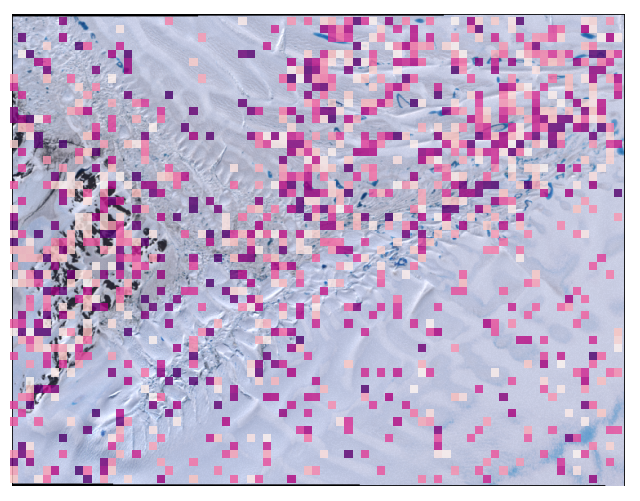

In [262]:
date = "2020-01-22"
w_shape = rcoll.get("E")
name = "tile-182"
target_res = 3000
w0 = [w for w in coll.windows if w.metadata["date"] == date and w.name == name][0]

"""rgb"""
with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
    meta = src.meta
    rgb_clipped, rgb_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

"""activeness"""
with rasterio.open(os.path.join(settings.dmg_folder, w0.file_delta_alpha_c)) as src:
    meta = src.meta
    delta_clipped, delta_transform = mask(dataset=src, shapes=[geom for geom in roi.data.rotate(sgl_utils.get_angle(roi.data))], crop=True)

crev_active = sgl_utils.create_active_crevasses_mask(delta_clipped, 45, 15)
crev_mask = np.zeros(crev_active.shape)
crev_mask[np.nan_to_num(crev_active, nan = -1) >= 0] = 1

fig, ax = plt.subplots(figsize = (size, size * dy / dx))
rplt.show(rgb_clipped, transform = rgb_transform, ax = ax)
rplt.show(crev_active, transform = delta_transform, ax = ax,  cmap = "RdPu", alpha = 0.8)
ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.show()
